# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

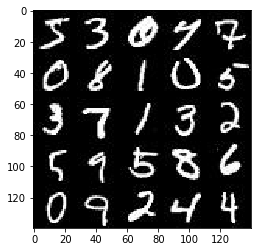

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

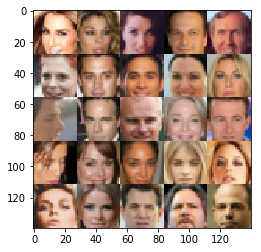

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\Joe\\Anaconda3\\envs\\tensorflow1.3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\Joe\\Anaconda3\\envs\\tensorflow1.3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\Joe\\Anaconda3\\envs\\tensorflow1.3\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\Joe\\Anaconda3\\envs\\tensorflow1.3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\Joe\\Anaconda3\\envs\\tensorflow1.3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instan

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha* x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        flat = tf.reshape( x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 4, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)

        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 4, strides=2, padding='same')

        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(generator_model, reuse=True)
    ce_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels= tf.ones_like(d_model_real))
    ce_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels= tf.zeros_like(d_model_fake))
    ce_g = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels= tf.ones_like(d_model_fake))
    d_loss_real = tf.reduce_mean(ce_real)
    d_loss_fake = tf.reduce_mean(ce_fake) 
    g_loss = tf.reduce_mean(ce_g) 
    return d_loss_real+d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainables = tf.trainable_variables()
    disc_vars = [var for var in trainables if var.name.startswith('discriminator')]
    gen_vars = [var for var in trainables if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)

    return disc_opt, gen_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    sample_z = np.random.uniform(-1., 1., size=(100, z_dim) )
    samples, losses = [],[]
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    disc_opt, gen_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    show_every = 50
    print_every = 10
    #saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1., 1., size=(batch_size, z_dim))
                d_feed_dic = {input_real: batch_images, input_z: batch_z, lr: learning_rate}
                g_feed_dic = {input_z: batch_z, input_real: batch_images, lr: learning_rate}
                _ = sess.run(disc_opt, feed_dict=d_feed_dic)
                _ = sess.run(gen_opt, feed_dict=d_feed_dic)
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess=sess, n_images = 10, input_z = input_z, out_channel_dim = data_shape[3], image_mode = data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0443... Generator Loss: 8.5166
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 0.4830
Epoch 1/2... Discriminator Loss: 0.7267... Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 0.2309... Generator Loss: 13.2040
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 4.7141


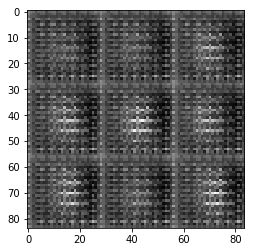

Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.5707
Epoch 1/2... Discriminator Loss: 1.8124... Generator Loss: 0.2545
Epoch 1/2... Discriminator Loss: 0.5073... Generator Loss: 1.5796
Epoch 1/2... Discriminator Loss: 0.5931... Generator Loss: 2.6064
Epoch 1/2... Discriminator Loss: 0.6912... Generator Loss: 1.7310


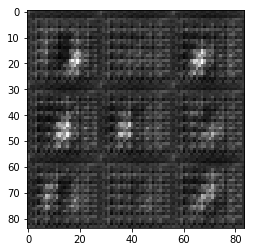

Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 1.6939
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 3.3467
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 1.6506
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.5038
Epoch 1/2... Discriminator Loss: 0.9102... Generator Loss: 0.9439


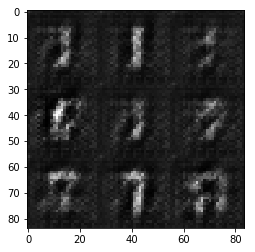

Epoch 1/2... Discriminator Loss: 1.4917... Generator Loss: 0.5441
Epoch 1/2... Discriminator Loss: 0.6599... Generator Loss: 1.4108
Epoch 1/2... Discriminator Loss: 1.2127... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 1.5064
Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 1.4538


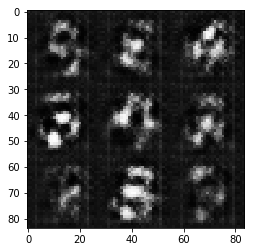

Epoch 1/2... Discriminator Loss: 0.9929... Generator Loss: 1.6775
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 2.0793
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 1.7543
Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 1.3161
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 1.7189


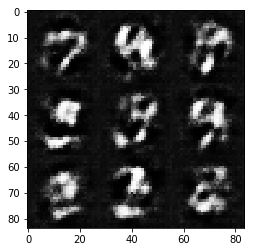

Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 1.4442
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 2.0502
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 0.9956
Epoch 1/2... Discriminator Loss: 0.9141... Generator Loss: 1.1210
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.2299


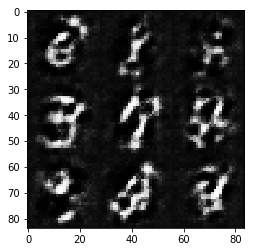

Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 1.1173
Epoch 1/2... Discriminator Loss: 0.9888... Generator Loss: 1.8049
Epoch 1/2... Discriminator Loss: 0.9325... Generator Loss: 1.5065
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 1.3765
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 2.3030


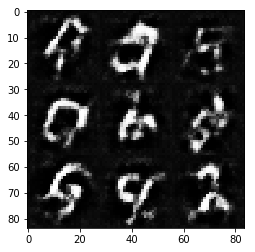

Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 1.9523
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 2.1156
Epoch 1/2... Discriminator Loss: 0.9215... Generator Loss: 0.9717
Epoch 1/2... Discriminator Loss: 1.1088... Generator Loss: 0.7166
Epoch 1/2... Discriminator Loss: 0.8916... Generator Loss: 0.8823


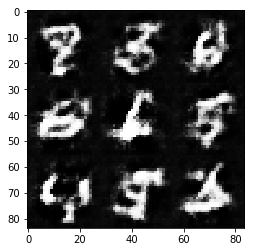

Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 1.9516
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 1.5257
Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 1.2668
Epoch 1/2... Discriminator Loss: 1.5217... Generator Loss: 2.5523


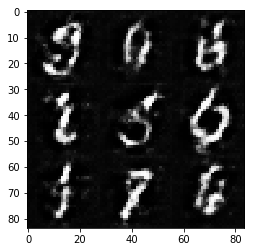

Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.4410
Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 0.4014
Epoch 2/2... Discriminator Loss: 1.2281... Generator Loss: 0.4647
Epoch 2/2... Discriminator Loss: 1.4841... Generator Loss: 0.3420


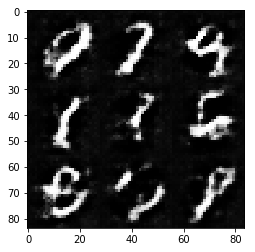

Epoch 2/2... Discriminator Loss: 0.8718... Generator Loss: 1.1173
Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 1.5489
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.5102
Epoch 2/2... Discriminator Loss: 1.2462... Generator Loss: 0.4841
Epoch 2/2... Discriminator Loss: 1.0267... Generator Loss: 1.2243


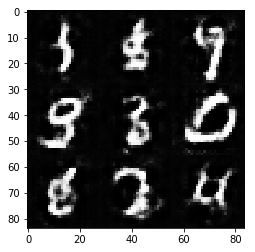

Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 1.3845
Epoch 2/2... Discriminator Loss: 1.1110... Generator Loss: 1.5495
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 1.8431... Generator Loss: 0.2098


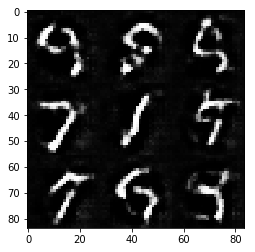

Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.7094
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 0.9702
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 1.7860
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 1.5025


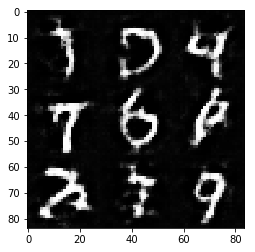

Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.6288
Epoch 2/2... Discriminator Loss: 1.1846... Generator Loss: 1.3468
Epoch 2/2... Discriminator Loss: 1.0852... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 0.9791... Generator Loss: 1.6070
Epoch 2/2... Discriminator Loss: 1.5958... Generator Loss: 0.2924


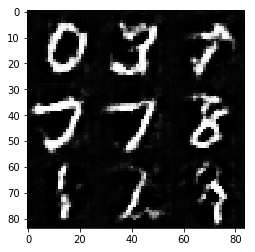

Epoch 2/2... Discriminator Loss: 1.1163... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 0.9706
Epoch 2/2... Discriminator Loss: 1.1469... Generator Loss: 1.3134
Epoch 2/2... Discriminator Loss: 1.0321... Generator Loss: 1.2180
Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 1.1507


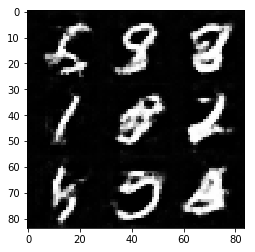

Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 1.1064... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.9145
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 0.8768
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 0.7916


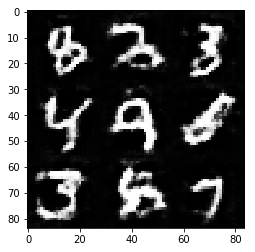

Epoch 2/2... Discriminator Loss: 1.0771... Generator Loss: 1.2961
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 1.1129
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 0.9930... Generator Loss: 1.1319
Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 0.5985


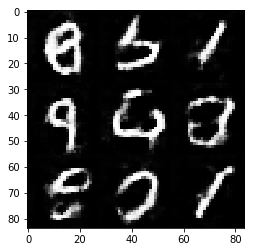

Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.8430
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 0.9099
Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 0.9911
Epoch 2/2... Discriminator Loss: 1.8658... Generator Loss: 0.2036


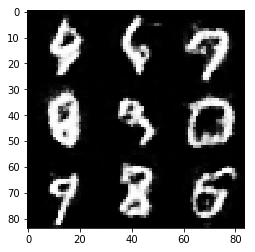

Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 0.9943
Epoch 2/2... Discriminator Loss: 1.0855... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 0.8620


In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2299... Generator Loss: 4.9116
Epoch 1/1... Discriminator Loss: 2.1836... Generator Loss: 0.1388
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 9.9155
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 5.5312
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 0.7273


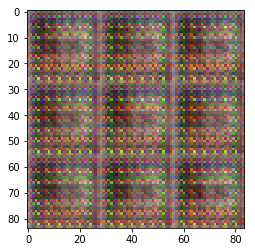

Epoch 1/1... Discriminator Loss: 3.0988... Generator Loss: 8.1195
Epoch 1/1... Discriminator Loss: 1.6200... Generator Loss: 3.2899
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 0.3117... Generator Loss: 2.2065
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 2.1903


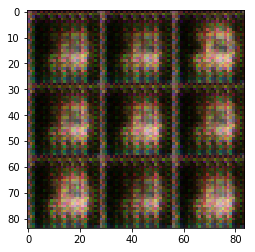

Epoch 1/1... Discriminator Loss: 1.9703... Generator Loss: 0.2074
Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 1.7529
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.2344


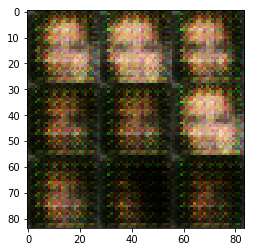

Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.9640
Epoch 1/1... Discriminator Loss: 0.7065... Generator Loss: 1.9767
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 1.1809
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 1.9360
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.5251


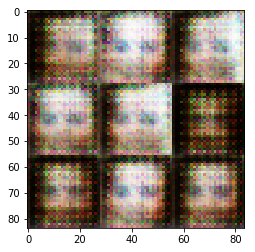

Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 1.4762
Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.4634
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.6995


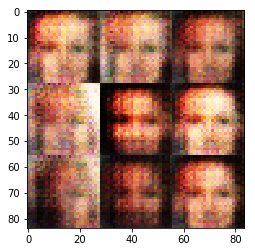

Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 1.5919
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 1.9661
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.2527


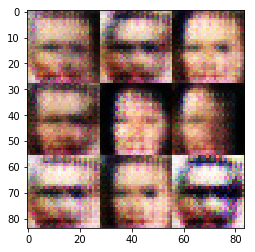

Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.9974


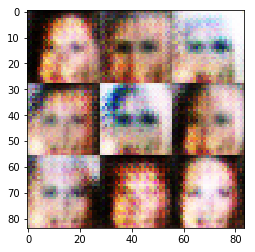

Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.2186


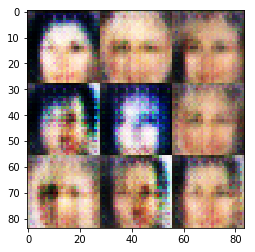

Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 2.3487
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 0.3928


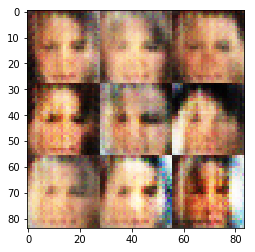

Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 2.1708
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 1.7664
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.8140


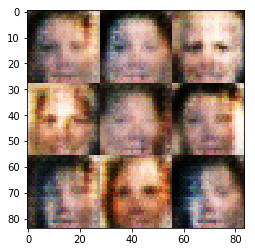

Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 1.9336
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7721


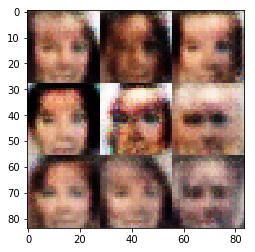

Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.8235


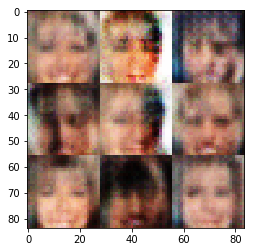

Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 1.8503
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 1.4975


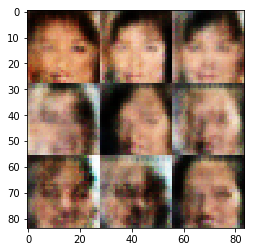

Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.2851
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.5123


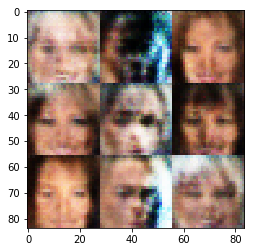

Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 1.1833


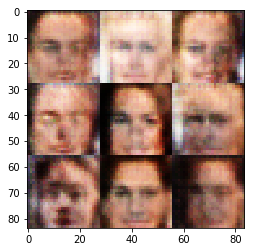

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.8204


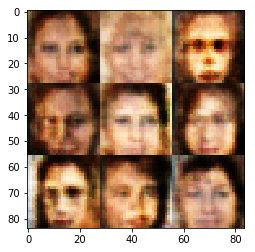

Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 1.4035
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 1.2562


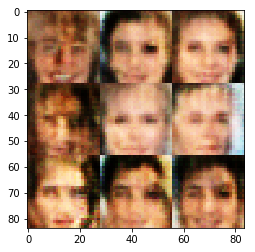

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.4659


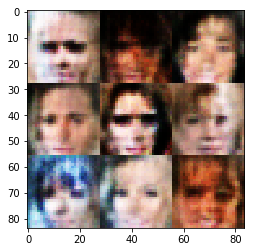

Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.3911


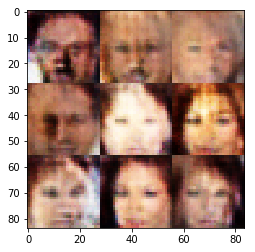

Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.5372
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.7096


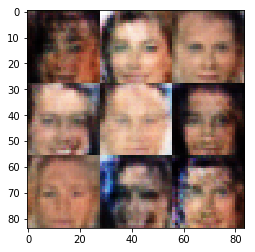

Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.6894


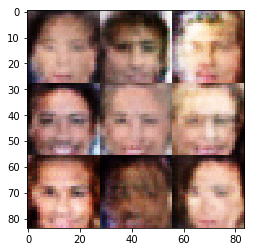

Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.6715... Generator Loss: 0.3538
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.8013


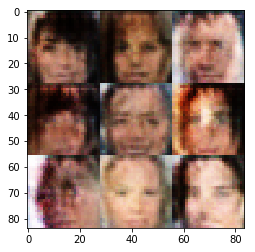

Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7597


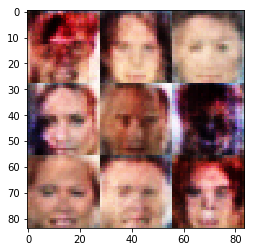

Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.2566


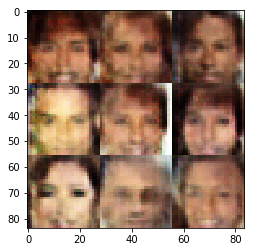

Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.8446


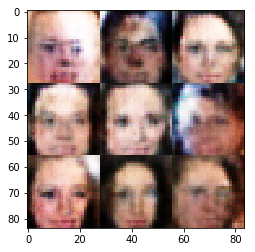

Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.5931


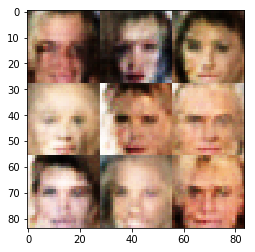

Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.3074


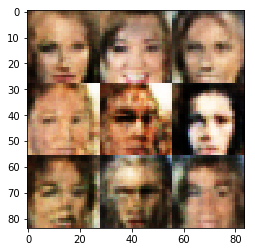

Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.3547
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8978


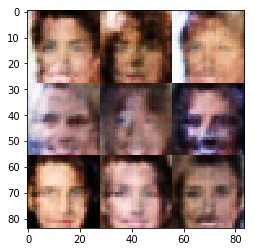

Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.5404


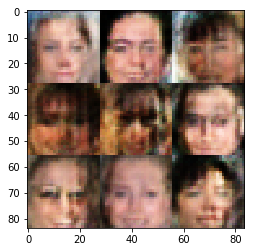

Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.8810... Generator Loss: 0.2519
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.6295


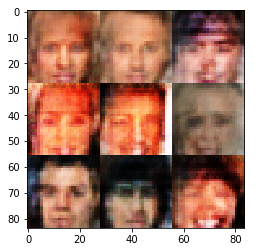

Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.8427


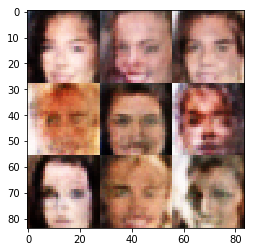

Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.0875


In [28]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.